In [2]:
import pandas as pd
from konlpy.tag import Okt
from numpy import ndarray
import warnings
import re 
from model.bow import BagOfWords
from model.tfidf import TfIdf
import yaml
warnings.filterwarnings("ignore")

C:\Users\gnsdl\AppData\Local\Temp\ipykernel_33428\1582215969.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# config
with open('configs/database.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
from utils.query_service import QueryService
query_service = QueryService(cfg['mysql'])

In [6]:
# 예제 : 쿼리하기
query_service.query_to_pandas_df('select * from review limit 10')

,id,member_id,board_id,badge_taste,badge_brix,badge_texture,rate,content,created_at,modified_at,is_deleted,is_best
0,1,-1,178,GOOD,NULL,NULL,3.0,일단 크기는 굉장히 작아요 성분이 괜찮아서 구매했는데 저는 그냥 한번 먹어본걸로 만족입니다 라즈베리 초코보다는 제 입에는 코코넛이 더 맛있게 느껴졌어요,2024-09-20,2024-09-20,0,0
1,2,-1,178,NULL,NULL,NULL,5.0,좋은 빵 많이 만들어주세요,2024-09-26,2024-09-26,0,0
2,3,-1,178,NULL,NULL,NULL,5.0,건강한 상품 잘 먹겠습니다,2024-06-29,2024-06-29,0,0
3,4,-1,178,GOOD,NULL,NULL,5.0,너무 맛있어요성분도 좋구요크기가 너무 작아서계속 먹게되네요ㅋ,2024-04-07,2024-04-07,0,0
4,5,-1,178,NULL,NULL,NULL,5.0,배송 좋았습니다. 고객센터 전화도 잘 되구요,2024-03-25,2024-03-25,0,0
5,6,-1,178,GOOD,PLAIN,NULL,5.0,생각보다 달지 않고 상큼하고 맛있음~2,2024-02-22,2024-02-22,0,0
6,7,-1,178,NULL,NULL,NULL,5.0,명절 선물로 보냈는데 좋아하셨습니다 ^^,2024-03-14,2024-03-14,0,0
7,8,-1,178,NULL,NULL,NULL,5.0,명절 선물로 보냈는데 좋아하셨습니다 ^^,2024-03-14,2024-03-14,0,0
8,9,-1,178,NULL,NULL,NULL,5.0,명절 선물로 보냈는데 좋아하셨습니다 ^^,2024-03-14,2024-03-14,0,0
9,10,-1,178,GOOD,NULL,NULL,5.0,주거형태거주인원 4인영유아 가정대체당이고 밀가루 안써서 좋은데 입터져서 무서워요 ㅠㅠ너무 맛있어요. 냉동실에 쟁여놓고 바로 꺼내먹어도 아이스 케이크 같아서 너무 맛있다는......(저는 키토식 오래해서 대체당과 저탄수 베이킹 자주 먹어서 제 기준에 맛있는 거지만 탄수인들 입맛에는 질감이 좀 그럴 수 있습니다.),2024-02-01,2024-02-01,0,0


#### Data Import

In [10]:
df = pd.read_csv('data/product_board_feature.csv', encoding='utf-8')

In [1]:
# NLP 
okt = Okt()
def tokenize(text):
    return ['/'.join(t) for t in okt.pos(text, norm=True, stem=True)]

# 자연어 데이터만 추출
nl_df = df[['id', 'title', 'flavor']]

NameError: name 'Okt' is not defined

In [90]:
nl_df['title'] = nl_df['title'].astype(str)
nl_df['flavor'] = nl_df['flavor'].astype(str)

#### Preprocessing

In [91]:
# 소문자로 변환
nl_df['title'] = nl_df['title'].str.lower()
nl_df['flavor'] = nl_df['flavor'].str.lower()

In [92]:
# 특수문자 제거
special_chars = '[^가-힣0-9a-zA-Z]'
nl_df['title'] = nl_df['title'].apply(lambda x: re.sub(special_chars, ' ', x))
nl_df['flavor'] = nl_df['flavor'].apply(lambda x: re.sub(special_chars, ' ', x))

In [93]:
# preprocessing Rule
# 목적 : token이 될 수 있는 유효한 단어만 남기기 위해 불필요한 단어의 종류를 정의하고 제거한다.
# 수량 제거
quantity_compiler = re.compile(r'\d+[개입|kg|팩|개|종|입|원|g]+')
nl_df['title'] = nl_df['title'].apply(lambda x: re.sub(quantity_compiler, ' ', x))
nl_df['flavor'] = nl_df['flavor'].apply(lambda x: re.sub(quantity_compiler, ' ', x))

In [94]:
# title과 option을 합쳐서 description을 만든다.
nl_df['description'] = nl_df['title'] + ' ' + nl_df['flavor'] 

In [96]:
# tokenizing
nl_df['token'] = nl_df['description'].apply(lambda x: okt.morphs(x))

In [11]:
# 중복 단어 제거 : 나열식의 중복 단어가 노이즈로 인식됨 
nl_df['token'] = nl_df['token'].apply(lambda x: list(set(x)))

In [98]:
# stopwords 제거
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
    stopwords = [x.strip() for x in stopwords]
nl_df['token'] = nl_df['token'].apply(lambda x: [word for word in x if word not in stopwords])

In [99]:
# description mutation : 
nl_df['description'] = nl_df['token'].apply(lambda x: ' '.join(x))

In [101]:
# id2idx
id2idx = {id:idx for idx, id in enumerate(nl_df['id'])}
idx2id = {idx:id for idx, id in enumerate(nl_df['id'])}

In [102]:
board_id_2_store_id = {board_id:store_id for board_id, store_id in zip(df['id'], df['store_id'])}

#### Fit

In [124]:
tfidf = TfIdf()
tfidf.fit(nl_df['description'])
tfidf.predict(1)

[(18, 0.3456217516488277),
 (64, 0.25081863662401455),
 (206, 0.23871484171563714),
 (54, 0.22201538445055624),
 (27, 0.21251889709074823),
 (85, 0.17885666037507125),
 (152, 0.17296888206507627),
 (143, 0.15937823328266346),
 (0, 0.15808489988972269),
 (162, 0.14093024310173788)]

In [125]:
bow = BagOfWords()
bow.fit(nl_df['description'])
bow.predict(1)

[(18, 0.4529108136578383),
 (152, 0.44232586846469146),
 (27, 0.4216370213557839),
 (64, 0.39629696195060854),
 (85, 0.3872983346207417),
 (162, 0.3872983346207417),
 (155, 0.3857583749052298),
 (103, 0.38507702310770275),
 (54, 0.3689323936863109),
 (125, 0.3689323936863109)]

#### Generate

In [126]:
def generate_recommendation(board_id: int, cosine_sim: ndarray=None, top_k: int=10, threshold: float=0.5) -> list:
    """
    1. 추천을 생성한다
    2. thresholding을 한다 
    3. 같은 스토어 상품을 제외한다
    4. topk를 뽑는다
        - 안되면 예외처리한다
    :params:
        id : int : product id
        cosine_sim : ndarray : cosine similarity matrix
        top_k : int : number of recommendation
        threshold : float : similarity threshold
    :return:
    """
    idx = id2idx[board_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # score 기준으로 정렬
    sim_scores = [i for i in sim_scores if i[1] > threshold]
    sim_scores = sim_scores[1:top_k+1] 
    candidate = [(board_id, idx2id[i], score) for i, score in sim_scores] # id, score 형태로 변환 
    product_indices = [i[0] for i in sim_scores]
    # print(product_indices)
    print('Query Item:\n ', df[['title', 'purchase_url']].iloc[idx])
    print('Recommendation Items:\n', df[['title', 'purchase_url']].iloc[product_indices], '\n', '------------------------')
    return candidate

In [21]:
result = generate_recommendation(board_id=15, cosine_sim=tfidf.cosine_matrix, top_k=3)

Recommendation Items:
         title  \
124  비건버터 쌀식빵   

                                                         purchase_url  
124  https://smartstore.naver.com/dearmyqueen1553/products/9022144231  


In [127]:
result = generate_recommendation(board_id=5, cosine_sim=bow.cosine_matrix, top_k=3)

Query Item:
  title                                              꾸디 비건쿠키 (르뱅쿠키 수제쿠키)
purchase_url    https://smartstore.naver.com/ggudi/products/5350602475
Name: 4, dtype: object
Recommendation Items:
                           title  \
166       스모어쿠키 르뱅 수제 아메리칸 비건쿠키   
30        비건쿠키 글루텐프리 쌀 수제 건강 간식   
128  비건이레 수제 비건 쿠키 얼그레이오망아메리칸쿠키   

                                                             purchase_url  
166              https://smartstore.naver.com/veganez/products/9899474228  
30            https://smartstore.naver.com/chopcookie/products/9606521978  
128  https://smartstore.naver.com/vegan_for_sevendays/products/5954319644   
 ------------------------


#### Postprocessing
- 같은 스토어의 제품은 나오지 않게 한다
- 품절된 상품은 나오지 않게 한다

In [23]:
board_id_2_store_id = {board_id:store_id for board_id, store_id in zip(df['id'], df['store_id'])}
def store_exist(board_id:int, recommended_store_id_set: set)->bool:
    store_id = board_id_2_store_id.get(board_id, None)
    return store_id in recommended_store_id_set

In [113]:
from collections import defaultdict
# boardid가 같은 storeid를 갖고있는지 확인
recommend_dict = defaultdict(list)
recommended_store_id_set = set()
for board_id, recommendation_board_id, score in result:
    recommended_store_id = board_id_2_store_id.get(recommendation_board_id, None)
    if len(recommend_dict[board_id]) < 3:
        if not store_exist(recommendation_board_id, recommended_store_id_set):
            recommended_store_id_set.add(recommended_store_id)
            recommend_dict[board_id].append((recommendation_board_id, score))

#### Metrics

In [128]:
from metrics.coverage import get_coverage

total_cnt = nl_df['id'].nunique()
rec_list = []
for board_id in nl_df['id']:
    result = generate_recommendation(board_id, bow.cosine_matrix, 3)
    rec_list.extend([x[1] for x in result])
rec_set = set(rec_list)
get_coverage(rec_set, total_cnt)

Query Item:
  title                                      냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건
purchase_url    https://smartstore.naver.com/nyangppang/products/5907549396
Name: 0, dtype: object
Recommendation Items:
                             title  \
135              비건 글루텐프리 베이글 [쑥]   
42   카카오 큐브 대체당 냥빵 글루텐프리 대체당 노밀가루   
26              비건 글루텐프리 베이글 [호박]   

                                                          purchase_url  
135  https://smartstore.naver.com/dearmyqueen1553/products/10408024042  
42         https://smartstore.naver.com/nyangppang/products/8303689276  
26   https://smartstore.naver.com/dearmyqueen1553/products/10408016820   
 ------------------------
Query Item:
  title                               비건 유기농 쌀 & 기장쌀 잡곡 비스코티 5종 미앤드리 글루텐프리
purchase_url    https://smartstore.naver.com/meandri/products/8173331858
Name: 1, dtype: object
Recommendation Items:
 Empty DataFrame
Columns: [title, purchase_url]
Index: [] 
 ------------------------
Query Item:
  title           

0.6398104265402843

In [120]:
from collections import Counter
agg_cnt = Counter(rec_list)

<BarContainer object of 131 artists>

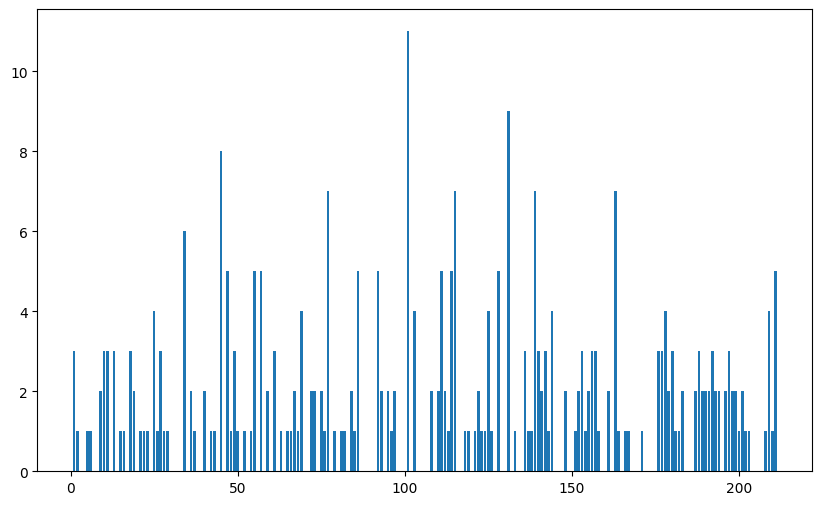

In [121]:
agg_df = pd.DataFrame.from_dict(agg_cnt, orient='index').reset_index()
agg_df.columns = ['id', 'count']
fig = plt.figure(figsize=(10, 6))
plt.bar(agg_df['id'], agg_df['count'])